# Plotting clusters on ternary diagrams

In this notebook, a data from cluster serach on RPV steel is processed and plotted on a ternary diagram.
Processing involves:
- filtering and sorting clusters via their size,
- filtering based on concentration of a specified ion type,
- plotting the data on a ternary diagram with regards their size using colormaps as well as different marker size
- plotting stacked column bars showing relative or absolute concentration of each cluster sorted by size
- line of Fe.

In [44]:
import xml_for_msm_with_relabelling as pgp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import subprocess
import pandas
import time
import sys
import plotly.graph_objects as go
import plotly.express as px

In [6]:
output_folder = "/home/pklups/posgenpy/ternary_diagrams_data/" # put "/" at the end
file_base_name = "TA3_F_330C_09569_o"
xml_files = ["/home/pklups/posgenpy/ternary_diagrams_data/TA3_F_330C_09569_o6.xml"]
dmax_values = [6]

In [7]:
# find the cluster stats file and create a dataframe
order = 6

file_name = file_base_name + str(order) + "_cluster-stats.txt"
df = pandas.read_csv(output_folder+file_name, sep="\t")

#check if works
df.head()

,X,Y,Z,Mo,Fe,Fm,Ni,C,Cu,Cr,Si,P,O,Mn,Ga,Unranged,r_gyration
0,-11.22120,-5.063000,9.01697,0,58,46,6,0,7,0,7,0,0,24,0,0,0.942796
1,-9.86361,-3.177880,12.24060,0,59,36,15,0,8,0,4,0,0,32,0,0,0.908223
2,-12.28840,-0.977973,21.73200,0,155,74,39,0,48,0,14,0,0,75,0,0,1.081110
3,15.63080,13.514000,56.42100,0,5,6,3,0,0,0,1,0,0,1,0,0,0.402365
4,12.16560,15.216400,50.61360,0,296,129,61,1,49,0,30,0,0,89,0,0,1.005510


## Plot stacked column graphs

First is copied from Plotting readl vs random clusters jupyter notebook

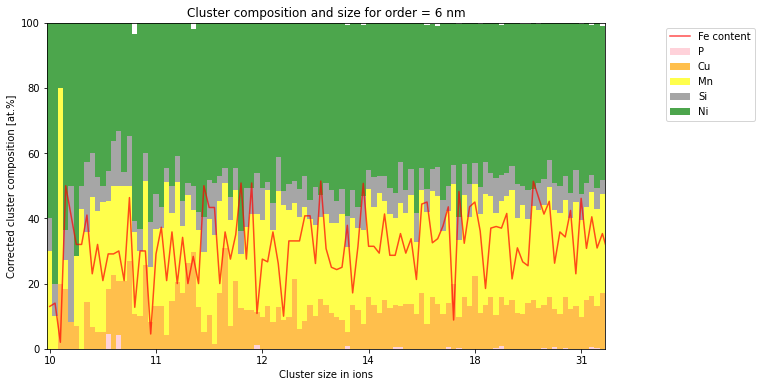

In [8]:
# same but with bar
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.90}
n_min = 10
core_ion_colors = {
    "Cu": "orange",
    "Ni": "green",
    "Mn": "yellow",
    "P": "pink",
    "Si": "grey"
}
plot_with_Fe = True

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["P", "Cu", "Mn", "Si", "Ni"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    plt.figure(figsize=(10, 6))
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    for i2, core_ion in enumerate(core_ions):
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
#         # for each cluster size find all clusters and calculate mean core ion content with stdev
#         for i3, x in enumerate(iter(x_values)):
#             all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
#             y_values[i3] = all_for_one_size.mean() / x * 100
#             y_std[i3] = all_for_one_size.std() / x * 100
#             # TODO: think about how to plot st dev later on
        
        if i2 == 0:
            plt.bar(x_values, y_values, width=1, alpha=0.7, label=core_ion, 
                    color=core_ion_colors[core_ion])
            previous_y_values = y_values
        else:
            plt.bar(x_values, y_values, bottom=previous_y_values, width=1, 
                    alpha=0.7, label=core_ion, color=core_ion_colors[core_ion])
            previous_y_values = previous_y_values + y_values
        
    # reopen pandas dataframe to get the Fe content and plot a line
    if plot_with_Fe:
        local_df = pandas.read_csv(cluster_stats_file, sep="\t")
                                
        # TODO: improve
        # transfer the overlapping ions into "original" elements
        local_df["Fe"] = local_df["Fe"] + (local_df["Fm"] * 0.1)
        # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
        local_df["Ni"] = local_df["Ni"] + (local_df["Fm"] * 0.9)

        # add total ions in cluster value
        local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)

        # change n_min
        local_df = local_df[local_df["Cluster Size"] >= n_min]

        # sort it by size
        local_df = local_df.sort_values(by="Cluster Size")

        Fe_concentration = local_df["Fe"] / local_df["Cluster Size"] * 100
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        # TODO: data smoothing?
        plt.plot(x_values, Fe_concentration, 'r-', label="Fe content", alpha=0.7)
        
    # adjust the plot    
    plt.xlabel("Cluster size in ions")
    plt.ylabel("Corrected cluster composition [at.%]")
    
    # prepare the x axis - plot every 20th value
    tick = 20
    cluster_size_values = cluster_size_values.astype(int)
    plt.xticks(x_values[::tick], cluster_size_values[::tick])
    plt.legend(bbox_to_anchor=(1.1, 1))
#     plt.grid()
    plt.xlim(-0.5, len(y_values)-0.5)
    plt.ylim(0, 100)
    plt.title("Cluster composition and size for order = %s nm"%dm)
    plt.show()


### Plotting using Plotly library


In [42]:
# same but with bar
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.90}
n_min = 10
core_ion_colors = {
    "Cu": "orange",
    "Ni": "green",
    "Mn": "yellow",
    "P": "pink",
    "Si": "grey"
}
plot_with_Fe = True

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["P", "Cu", "Mn", "Si", "Ni"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    # create a new figure
    fig = go.Figure()
    
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    x_values = np.arange(len(local_df["Cluster Size"]))
    for i2, core_ion in enumerate(core_ions):
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
#         # for each cluster size find all clusters and calculate mean core ion content with stdev
#         for i3, x in enumerate(iter(x_values)):
#             all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
#             y_values[i3] = all_for_one_size.mean() / x * 100
#             y_std[i3] = all_for_one_size.std() / x * 100
#             # TODO: think about how to plot st dev later on

        fig.add_trace(go.Bar(
            x=x_values, 
            y=y_values, 
            name=core_ion,
            marker_color=core_ion_colors[core_ion]
        ))

        
        
    # reopen pandas dataframe to get the Fe content and plot a line
    if plot_with_Fe:
        local_df = pandas.read_csv(cluster_stats_file, sep="\t")
                                
        # TODO: improve
        # transfer the overlapping ions into "original" elements
        local_df["Fe"] = local_df["Fe"] + (local_df["Fm"] * 0.1)
        # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
        local_df["Ni"] = local_df["Ni"] + (local_df["Fm"] * 0.9)

        # add total ions in cluster value
        local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)

        # change n_min
        local_df = local_df[local_df["Cluster Size"] >= n_min]

        # sort it by size
        local_df = local_df.sort_values(by="Cluster Size")

        Fe_concentration = local_df["Fe"] / local_df["Cluster Size"] * 100

        # TODO: data smoothing?
        # plt.plot(x_values, Fe_concentration, 'r-', label="Fe content", alpha=0.7)
        fig.add_trace(go.Line(x=x_values, y=Fe_concentration, name="Fe", opacity=0.7, line_color="red"))
        
    # adjust the plot
    fig.update_layout(
        barmode="stack", 
        title_text="Core Ion concentration"
    )

    # Set custom x-axis labels
    how_many_ticks = 15
    print(len(x_values))
    interval = round(len(x_values) / how_many_ticks)

    
    ticktext_data = local_df["Cluster Size"][::interval]
    ticktvals_data = x_values[::interval]

    
    fig.update_xaxes(
        ticktext=ticktext_data,
        tickvals=ticktvals_data,
        title_text="Cluster Size in Ions"
    )

    fig.update_yaxes(
        title_text="Concentration in at. %"
    )

    fig.show()



105


## Ternary Diagrams

### Plotting using Plotly library

In [40]:
# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Mn", "Si", "Ni", "Cu"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    # then core ions / total ions to know the absolute concentration 
    for i2, core_ion in enumerate(core_ions):
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
    # find the sum of ternary ions in each cluster    
    local_df["Relative Cluster Size"] = local_df["Ni"] + local_df["Cu"] + local_df["Mn"] + local_df["Si"]
    
    # once you have sum of ternary ions in each cluster, find relative concentration of each core ion
    local_df["Relative Ni+Mn"] = (local_df["Ni"] + local_df["Mn"]) / relative_cluster_size
    local_df["Relative Si"] = local_df["Si"] / relative_cluster_size
    local_df["Relative Cu"] = local_df["Cu"] / relative_cluster_size



    # plotting using plotly ternary diagrams
#     fig = px.scatter_ternary(local_df, a="relative_Ni_Mn", b="relative_Si", c="relative_Cu")
    fig = px.scatter_ternary(
        local_df, a="Ni", b="Si", c="Mn", 
        hover_name="Cluster Size",
        size="Cluster Size", size_max=20,
        color="Cluster Size", color_continuous_scale=px.colors.sequential.Viridis,
        opacity=0.6
#         marker=dict(
#             color='LightSkyBlue',
#             size='Relative Cluster Size',
#             size_max = 15,
#             opacity=0.5,
#             line=dict(
#                 color='MediumPurple',
#                 width=5
#             )
#         )
    )
    
    fig.show()

In [55]:
# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Mn", "Si", "Ni", "Cu"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    # then core ions / total ions to know the absolute concentration 
    for i2, core_ion in enumerate(core_ions):
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
    # find the sum of ternary ions in each cluster    
    local_df["Relative Cluster Size"] = local_df["Ni"] + local_df["Cu"] + local_df["Mn"] + local_df["Si"]
    
    # once you have sum of ternary ions in each cluster, find relative concentration of each core ion
    local_df["Ni+Mn"] = local_df["Ni"] + local_df["Mn"]
    # local_df["Relative Si"] = local_df["Si"] / relative_cluster_size
    # local_df["Relative Cu"] = local_df["Cu"] / relative_cluster_size

    # create column with negative z location 
    local_df["Z Axis"] = local_df["Z"] * -1

    # plotting using plotly ternary diagrams
#     fig = px.scatter_ternary(local_df, a="relative_Ni_Mn", b="relative_Si", c="relative_Cu")
    fig = px.scatter_ternary(
        local_df, a="Ni+Mn", b="Si", c="Cu", 
        hover_name="Cluster Size", # change later to show cluster ID
        size="Cluster Size", size_max=20,
        color="Z Axis", color_continuous_scale=px.colors.sequential.Viridis,
        opacity=0.6
#         marker=dict(
#             color='LightSkyBlue',
#             size='Relative Cluster Size',
#             size_max = 15,
#             opacity=0.5,
#             line=dict(
#                 color='MediumPurple',
#                 width=5
#             )
#         )
    )
    fig.show()


    fig2 = px.scatter_3d(
        local_df, x='X', y='Y', z='Z Axis',
        color='Z Axis', color_continuous_scale=px.colors.sequential.Viridis,
        size='Cluster Size', size_max=30,
        opacity=0.6
    )

    fig2.show()